## Objectifs du notebook

L'objectif de ce notebook est de parvenir à créer un modèle de classification des visages. Vous avez à votre disposition le dossier yalefacesgif. Ce dataset regroupe en tout 15 sujets différents avec chacun 11 images, votre objectif est de prendre une partie de ces données et de procéder à une reconnaissance du reste utilisant le HoG comme descripteur suivi du classifieur de votre choix au sein de Scikit-learn. 

En clair vos objectifs c'est : 
- Prendre en main le jeux de données donné 
- Lire les images de chaque classes
- Faites un pré-traitement des images
- Appliquer le HoG sur les images et extraire le vecteur caractéristiques de ces dernières
- Procéder à la classification des images via le modèle de votre choix au sein de scikit-learn
- Evaluer les performances du (ou des) modèle(s) proposé(s)

In [53]:
import cv2 as cv
import numpy as np
import seaborn as sns 
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve, GridSearchCV, train_test_split
from sklearn import metrics

from skimage.feature import hog 

import os 
import glob

import skimage.io as skio

## Importation des modèles de classification

Importez les modèles que vous voulez utiliser dans ce challenge à partir de scikit-learn

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Lecture des images

Créer une fonction permettant la lecture des images ainsi que la création d'une liste contenant le label (subject-1, subject-2, etc.)

In [55]:
def load_images_labels(dataset) : 
    subjects = os.listdir(dataset)
    labels = []
    images = []
    for subject in subjects : 
        subject_path = os.path.join(dataset, subject)
        images_path = glob.glob(os.path.join(subject_path, "*.bmp"))
        images_subject = [skio.imread(image_path) for image_path in images_path]
        labels_subject = [subject for i in range(len(images_path))]
        
        labels += labels_subject
        images += images_subject

    return images, labels

dataset = "./yalefacesgif/"

images, labels = load_images_labels(dataset=dataset)

#### Optionnel : Transformation de l'image pour l'affichage

Les images lues actuellement ont une structure comme suit

In [44]:
images[0].shape

(1, 243, 320)

Pour avoir l'affichage de l'image via OpenCV ou Matplotlib on devrait avoir une structure comme suit (H,W,C) avec H c'est la hauteur, W la largeur, et C le nombre de canaux

In [56]:
# fonction Lambda
transform_images = lambda images: [np.expand_dims(np.squeeze(image), axis=-1) for image in images]

images = transform_images(images)

images[0].shape

(243, 320, 1)

Text(0.5, 1.0, 'subject01')

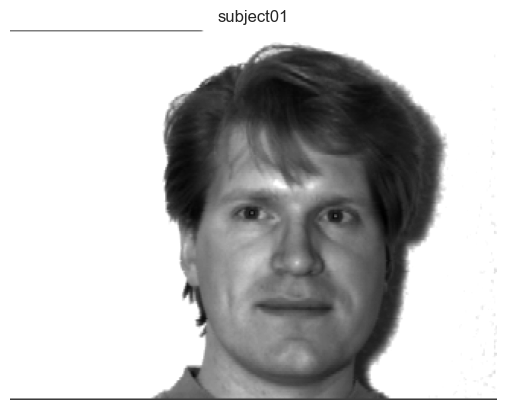

In [46]:
plt.imshow(images[0], cmap="gray")
plt.grid(False)
plt.axis("off")
plt.title(labels[0])

## Appliquer un filtre Gaussien sur les images

Utilisant OpenCV appliquez un filtre gaussien sur les images du jeux de données proposé

Text(0.5, 1.0, 'subject01')

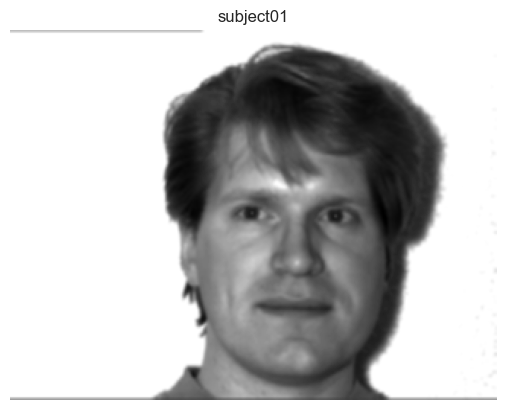

In [7]:
# fonction Lambda
gaussian_blur = lambda images: [cv.GaussianBlur(image, (3,3), 0) for image in images]

images = gaussian_blur(images)

plt.imshow(images[0], cmap="gray")
plt.grid(False)
plt.axis("off")
plt.title(labels[0])

L'ajout d'un filtre Gaussien rajoute du flou à l'image, dans le cas de notre image vous pouvez voir qu'il est alors superflux

## Redimensionner les images à une taille de 64 x 64

Utilisant OpenCV créez une fonction permettant le redimensionnement des images de votre jeux de données

Text(0.5, 1.0, 'subject01')

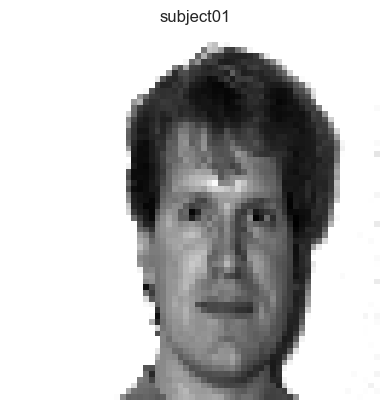

In [57]:
# fonction Lambda
resizer = lambda images: [np.expand_dims(cv.resize(image, (64,64)), axis=-1) for image in images]

images = resizer(images)

plt.imshow(images[0], cmap="gray")
plt.grid(False)
plt.axis("off")
plt.title(labels[0])

## Appliquez le HoG

Utilisant scikit-image appliquez le HoG sur toutes les images de votre jeux de données et extrayez les vecteurs caractéristiques. Donnez la taille de ces vecteurs

In [58]:
def hog_images (images, orientations:int=9, pixels_per_cell:tuple=(8,8), cells_per_block:tuple=(2,2)) :
    features = list()
    for image in images :
        feature, _ = hog(
            image, 
            orientations=orientations,
            pixels_per_cell=pixels_per_cell, 
            cells_per_block=cells_per_block, 
            visualize=True, 
            channel_axis=-1)
        features.append(feature)
    
    return features

In [59]:
features = hog_images(images)

In [60]:
features[0].shape

(1764,)

## Créer les ensembles d'entrainement et de test

Subdivisez le jeux de données en deux ensembles, un jeux de données d'entrainement ainsi qu'un jeux de données de test (en subdivisant de la même manière les labels évidemment). Mettez 60% du jeux de données pour l'entrainement. 

Remarque : Assurez vous d'avoir le même nombre d'images d'entrainement pour tous les sujets

In [61]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=123)

## Classification

Utilisant le(s) modèle(s) que vous avez sélectionné, mettez en place un classifieur réussissant à différencier les différents sujets de ce jeux de données. 

Utilisez GridSearchCV pour sélectionner les paramètres optimaux pour la classification

### KNN

In [62]:
# la mesure de distance est mise par défaut et c'est donc une distance Euclidienne
knn_parameters = {'n_neighbors':np.arange(1,20,2), 'p' : np.arange(1,4,1)}
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, knn_parameters, scoring='accuracy', cv=3)
clf.fit(features_train,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

knn=KNeighborsClassifier(**clf.best_params_)
knn.fit(features_train,labels_train)

knn_N, knn_train_score, knn_val_score = learning_curve(knn, features_train, labels_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = 3)

Les meilleurs paramètres sont : {'n_neighbors': 1, 'p': 1}


### Random Forest

In [63]:
forest_parameters = {'n_estimators' : np.arange(50, 251, 10), 'criterion' : ['gini', 'entropy', 'log_loss'], 'max_features' : ['sqrt', 'log2']}
forest = RandomForestClassifier()
clf = GridSearchCV(forest, forest_parameters, scoring='accuracy', cv=3)
clf.fit(features_train,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

forest=RandomForestClassifier(**clf.best_params_)
forest.fit(features_train,labels_train)

forest_N, forest_train_score, forest_val_score = learning_curve(forest, features_train, labels_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = 3)

Les meilleurs paramètres sont : {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 230}


### Adaboost

En terme de simplicité on va garder l'estimateur de base par défaut (un arbre de décision)

In [64]:
adaboost_parameters = {"n_estimators" : np.arange(50, 151, 5), 'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]}

adaboost = AdaBoostClassifier()
clf = GridSearchCV(adaboost, adaboost_parameters, scoring='accuracy', cv=3)
clf.fit(features_train,labels_train)

print(f"Les meilleurs paramètres sont : {clf.best_params_}")

adaboost = AdaBoostClassifier(**clf.best_params_)
adaboost.fit(features_train,labels_train)

adaboost_N, adaboost_train_score, adaboost_val_score = learning_curve(adaboost, features_train, labels_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = 3)

Les meilleurs paramètres sont : {'learning_rate': 0.1, 'n_estimators': 60}


## Evaluation du modèle

Pour l'évaluation du modèles veuillez afficher : 
- La courbe d'apprentissage (learning curve)
- L'accuracy
- La matrixe de confusion

Commentez les résultats obtenus

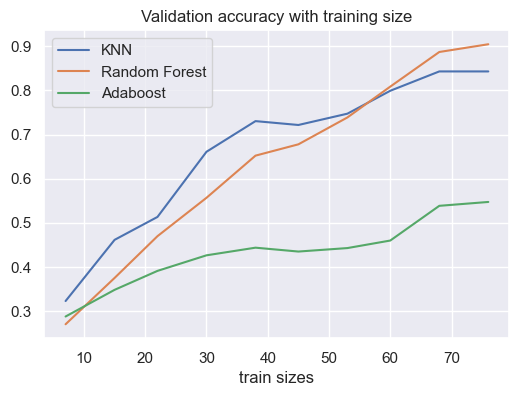

In [65]:
plt.figure(figsize=(6,4))
plt.plot(knn_N, knn_val_score.mean(axis=1), label='KNN')
plt.plot(forest_N, forest_val_score.mean(axis=1), label='Random Forest')
plt.plot(adaboost_N, adaboost_val_score.mean(axis=1), label='Adaboost')
plt.xlabel('train sizes')
plt.title("Validation accuracy with training size")
plt.legend()

In [66]:
yknn = knn.predict(features_test)
yforest = forest.predict(features_test)
yadaboost = adaboost.predict(features_test)

print(f"L'accuracy du KNN est de : {metrics.accuracy_score(labels_test, yknn)*100:.2f}%")
print(f"L'accuracy du Random Forest est de : {metrics.accuracy_score(labels_test, yforest)*100:.2f}%")
print(f"L'accuracy du Adaboost est de : {metrics.accuracy_score(labels_test, yadaboost)*100:.2f}%")

L'accuracy du KNN est de : 86.00%
L'accuracy du Random Forest est de : 86.00%
L'accuracy du Adaboost est de : 64.00%


Text(0.5, 1.0, 'Confusion matrix KNN')

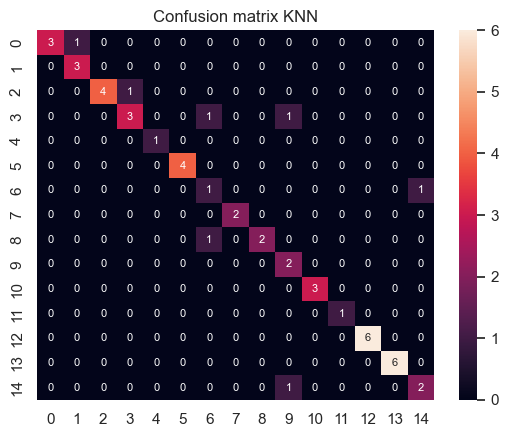

In [67]:
sns.heatmap(metrics.confusion_matrix(labels_test, yknn), annot=True, annot_kws={"size": 8})
plt.title("Confusion matrix KNN")

Text(0.5, 1.0, 'Confusion matrix Random Forest')

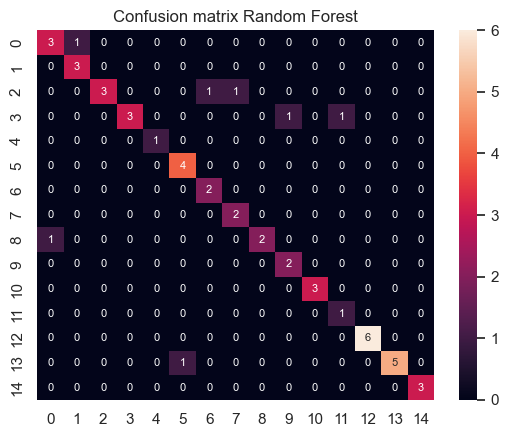

In [68]:
sns.heatmap(metrics.confusion_matrix(labels_test, yforest), annot=True, annot_kws={"size": 8})
plt.title("Confusion matrix Random Forest")

Text(0.5, 1.0, 'Confusion matrix Adaboost')

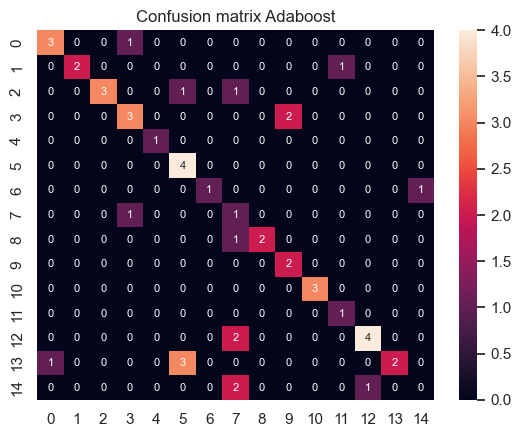

In [69]:
sns.heatmap(metrics.confusion_matrix(labels_test, yadaboost), annot=True, annot_kws={"size": 8})
plt.title("Confusion matrix Adaboost")

## Quelques précisions

Ce notebook ne représente pas forcément la meilleure approche à suivre pour avoir le meilleur résultat possible, l'objectif premier de ce notebook est éducatif et informatif, l'ajout d'un filtre gaussien ou du resize est éventuellement en trop. 

L'objectif alors à travers de ce notebook est d'appréhender différentes transformation habituellement utilisée en traitement d'imageet donc je vous invite à vous documenter pour améliorer vos résultats. J'ai pu avoir 100% d'accuracy, à vous de voir comment l'atteindre

Autre choses, la subdivision du jeu de données a été faite aléatoirement et donc durant l'entrainement les classes n'ont plus la même taille, comment changer le code pour avoir toujours le meme nombre d'images par classes dans le jeu de données d'entrainement ?